In [1]:
library(pacman)
p_load(dplyr,glarma,boot)

In [2]:
setwd('C:\\Users\\Marcelo\\OneDrive\\Área de Trabalho\\ts\\glarma')
getwd()

[1] "C:/Users/Marcelo/OneDrive/Área de Trabalho/ts/glarma"

# Simulação

Criando a função que simula o processo:

In [55]:
simulate_glarma <- function(T = 100, burn_in=50, beta = 1, theta = 0.3, x = NULL) {

  T_total <- T + burn_in
  
  if (is.null(x)) x <- rep(1, T_total)
  
  z <- numeric(T_total)
  mu <- numeric(T_total)
  y <- numeric(T_total)
  e <- numeric(T_total)
  
  for (t in 1:T_total) {
    z_t <- 0
    if (t > 1) z_t <- + e[t - 1] * theta
    
    eta <- beta * x[t] + z_t
    mu[t] <- exp(eta)
    y[t] <- rpois(1, lambda = mu[t])
    e[t] <- (y[t] - mu[t]) / sqrt(mu[t])
    z[t] <- z_t
  }
  
  return(data.frame(time = 1:T, x = x[(burn_in + 1):T_total], y = y[(burn_in + 1):T_total],
                    mu = mu[(burn_in + 1):T_total], z = z[(burn_in + 1):T_total],e=e[(burn_in + 1):T_total]))
}

Vou conferir se a simulação está correta:

In [56]:
Amostra_original<-simulate_glarma(T=100,beta=1,theta=0.3,x=NULL)

In [57]:
length(Amostra_original$y)

[1] 100

In [58]:
summary(Amostra_original$y)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    3.00    2.60    3.25    8.00 

In [59]:
X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [60]:
result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")

In [61]:
Theta<-result$delta[2]
Theta

theta_1 
0.2948244

In [62]:
Beta<-result$delta[1]
Beta

Intercept 
0.9297579

Conseguimos recuperar os parâmetros bem, está tudo certo.

# Bootstrap paramétrico:

Antes de criar as funções para rodar o experimento Monte Carlo, vou ver se a minha ideia do bootstrap está funcionando.

In [17]:
T=length(Amostra_original$y)
B=100

gerando as amostras bootstrap:

In [18]:
mu<-Amostra_original$mu

In [19]:
length(mu)

[1] 100

In [20]:
Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)

In [22]:
for (b in 1:B){
    r = simulate_glarma(T=T,beta=1,theta=Theta,x=NULL) 
    Y_Bootstrap[,b] <- r$y
    }

criando uma função que retorna os parâmetros estimados a partir de uma amostra:

In [2]:
recupera_par <- function(Y_col,X) {
  fit <- tryCatch({
    glarma(Y_col, X, phiLags = NULL, thetaLags = c(1), type = "Poi")
  }, error = function(e) {
    message("GLARMA failed to converge: ", e$message)
    return(NULL)
  })
  
  if (!is.null(fit) && !is.null(fit$delta) && length(fit$delta) >= 2 && is.numeric(fit$delta)) {
    return(c(beta = fit$delta[1],theta = fit$delta[2])
    )
  } else {
    return(c(beta = NA,theta = NA)
    )
  }
}

estimando os parâmetros para B amostras bootstrap.

In [24]:
par_estimates <- t(apply(Y_Bootstrap, 2, function(y_col) recupera_par(y_col, X)))

In [25]:
beta=par_estimates[,1]
theta=par_estimates[,2]

In [26]:
par_estimates=list('beta'=beta[!is.na(beta)],'theta'=theta[!is.na(theta)])

A média (nas B amostras) das parâmetros está perto do valor dos parâmetros para amostar original.

In [27]:
mean(par_estimates$beta,na.rm=TRUE)
mean(par_estimates$theta,na.rm=TRUE)

[1] 1.001969

[1] 0.3371344

In [28]:
quantile(par_estimates$theta,probs=c(0.025,0.975))

2.5%     97.5% 
0.2407814 0.4164569

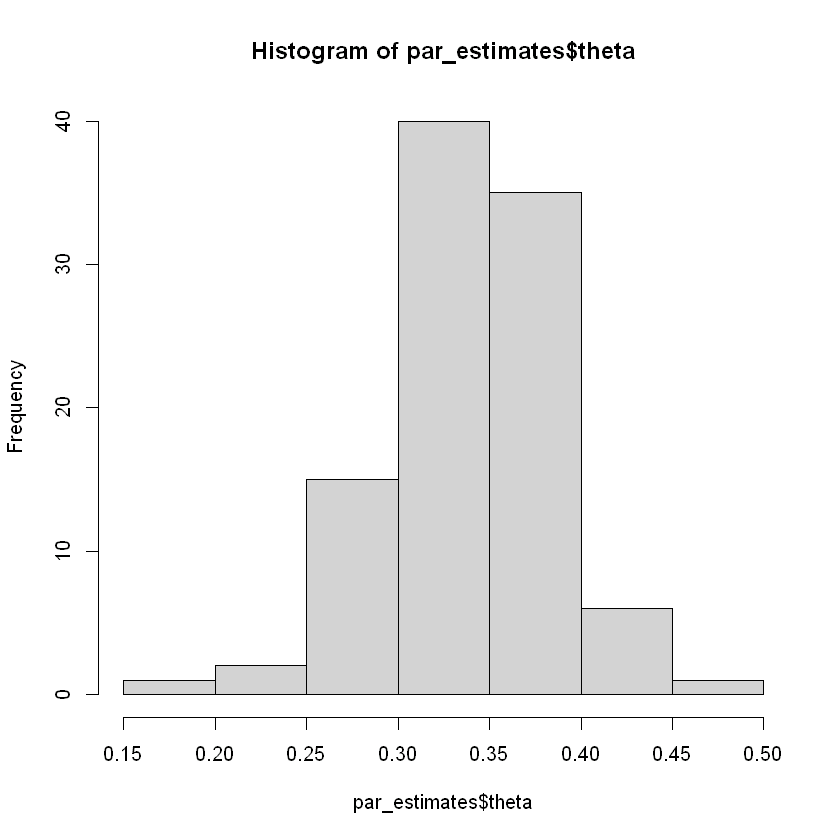

In [29]:
hist(par_estimates$theta)

Nossa ideia para o bootstrap está funcionando, vamos fazer o experimento monte carlo:

### Questão 1

Criando a função que faz o Bootstrap paramétrico. 
Ela retorna o valor dos parâmetros estimados na amostra original.
Além disso, retorna os vetores Beta_boostrap e Theta_bootstrap com as estimativas para os parâmetros na amostra bootstrap.
Ela também retorna a média do Beta_bootstrap e Theta_bootstrap e seus intervalos de confiança.
Finalmente, ela também retorna a Amostra original.

In [47]:
bootstrap_parametrico <- function(B=100,T=100,beta=1,theta=0.3)

    {

    Amostra_original<-simulate_glarma(T=T,beta=1,theta=0.3,x=NULL)
    X <- Amostra_original$x
    X <- as.matrix(X)
    colnames(X) <- "Intercept"

    result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    beta_estimado<-result$delta[1]
    theta_estimado<-result$delta[2]

    T=length(Amostra_original$y)
    mu<-result$mu

    Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)

    for (b in 1:B)
        {
        s = simulate_glarma(T=T,beta=beta_estimado,theta=theta_estimado,x=NULL) 
        Y_Bootstrap[,b] <- s$y
        }
    
    par_bootstrap <- t(apply(Y_Bootstrap, 2, function(y_col) recupera_par(y_col, X)))
                             
    beta_bootstrap=par_bootstrap[,1]
    theta_bootstrap=par_bootstrap[,2]
    
    par_bootstrap=list('beta'=beta_bootstrap[!is.na(beta_bootstrap)],'theta'=theta_bootstrap[!is.na(theta_bootstrap)])

    
    mean_beta <- mean(par_bootstrap$beta)
    mean_theta <- mean(par_bootstrap$theta)

    IC_theta<-quantile(par_bootstrap$theta, probs = c(0.025, 0.975))
    IC_beta<-quantile(par_bootstrap$beta, probs = c(0.025, 0.975))

            
    return(list('beta_estimado'=beta_estimado,
                'Beta_bootstrap'=par_bootstrap[1],
                'theta_estimado'=theta_estimado,
                'Theta_bootstrap'=par_bootstrap[2],
                'mean_beta'=mean_beta,
                'mean_theta'=mean_theta,
                'IC_theta'=IC_theta,
                'IC_beta'=IC_beta,
                'Amostra_original'= Amostra_original$y))
    }

Para ficar claro, vou rodar a função 1 vez com B=10 para ser possível ver o output:

In [34]:
bootstrap_parametrico(B=10)

$beta_estimado
Intercept 
0.9641791 

$Beta_bootstrap
$Beta_bootstrap$beta
 [1] 0.9455382 1.2197333 1.0363918 0.9478180 0.9954444 1.1212086 0.9130322
 [8] 1.0147689 0.9766725 1.1008948


$theta_estimado
  theta_1 
0.3397252 

$Theta_bootstrap
$Theta_bootstrap$theta
 [1] 0.4030557 0.3798982 0.3303246 0.3490297 0.3057418 0.3657739 0.3856037
 [8] 0.3849912 0.3599584 0.2446492


$mean_beta
[1] 1.02715

$mean_theta
[1] 0.3509026

$IC_theta
    2.5%    97.5% 
0.258395 0.399129 

$IC_beta
     2.5%     97.5% 
0.9203461 1.1975653 

$Amostra_original
  [1] 0 0 1 1 0 3 3 4 3 3 5 4 5 2 0 1 2 0 0 2 6 5 3 2 1 1 5 7 9 6 1 5 5 3 1 1 3
 [38] 3 2 1 3 3 1 3 2 4 5 5 2 1 2 3 5 1 2 3 3 3 3 3 1 2 2 7 9 2 1 1 4 3 2 3 1 2
 [75] 4 5 0 4 7 2 1 1 0 1 3 4 4 7 5 1 3 5 5 1 1 2 4 3 0 2

A função Questao1 faz o experimento Monte Carlo.Ela retorna:

um vetor de tamanho R com os parâmetros estimados da Amostra original de cada iteração (r in 1:R).

um vetor de tamanho R (r 1:R) com a média (em b 1:B) dos parâmetros bootstrap em cada iteração r.

uma lista de tamanho R com de intervalo de confiança bootstrap para cada parâmetro.

Além disso retorna quatro escalares:

mean_theta_dif_boot_est <- média (em r 1:R) de (mean_theta_bootstrap[r] - theta_estimado[r])^2 
( erro quadrático médio entre o theta estimado original e a média do theta_bootstrap)

theta_dif_boot_true;  média (em r 1:R) de (mean_theta_bootstrap[r] - theta)^2
( erro quadrático médio entre o theta verdadeiro e a média do theta_bootstrap)

Raciocínio análago para o beta.


In [4]:
Questao1 <- function(B = 20, T = 100, beta = 1, theta = 0.3, R = 2) {
  
  theta_estimado <- numeric(R)
  beta_estimado <- numeric(R)
  mean_theta_bootstrap <- numeric(R)
  mean_beta_bootstrap <- numeric(R)
  IC_theta_bootstrap <- vector("list", R)
  IC_beta_bootstrap <- vector("list", R)
  theta_dif_boot_true <- numeric(R)
  theta_dif_boot_est <- numeric(R)
  beta_dif_boot_true <- numeric(R)
  beta_dif_boot_est <- numeric(R)

  
  for (r in 1:R) {
    result <- tryCatch({
      bootstrap_parametrico(B = B, T = T, beta = beta, theta = theta)
    }, error = function(e) {
      message(sprintf("Erro na repetição %d: %s", r, e$message))
      return(NULL)
    })
    
    if (!is.null(result)) {
        mean_theta_bootstrap[r] <- result$mean_theta
        mean_beta_bootstrap[r] <- result$mean_theta
        IC_theta_bootstrap[[r]] <- result$IC_theta
        IC_beta_bootstrap[[r]] <- result$IC_beta
        theta_estimado[r] <- result$theta_estimado
        beta_estimado[r] <- result$beta_estimado

        theta_dif_boot_est[r] <- (mean_theta_bootstrap[r] - theta_estimado[r])^2
        theta_dif_boot_true[r] <- (mean_theta_bootstrap[r] - theta)^2

        beta_dif_boot_est[r] <- (mean_beta_bootstrap[r] - beta_estimado[r])^2
        beta_dif_boot_true[r] <- (mean_beta_bootstrap[r] - beta)^2

    } else {
      mean_theta_bootstrap[r] <- NA
      mean_beta_bootstrap[r] <- NA

      IC_theta_bootstrap[[r]] <- c(NA, NA)
      IC_beta_bootstrap[[r]] <- c(NA, NA)
      theta_estimado[r] <- NA
      beta_estimado[r]<-NA
        
    theta_dif_boot_est[r] <- NA
    theta_dif_boot_true[r] <- NA

    beta_dif_boot_est[r] <- NA
    beta_dif_boot_true[r] <- NA
    }


  }
  
  return(list(
    'theta_estimado' = theta_estimado,
    'beta_estimado' = beta_estimado,
    'mean_theta_bootstrap' = mean_theta_bootstrap,
    'mean_beta_bootstrap' = mean_beta_bootstrap,
    'IC_theta_bootstrap' = IC_theta_bootstrap,
    'IC_beta_bootstrap' = IC_beta_bootstrap,
    'mean_theta_dif_boot_est' = mean(theta_dif_boot_est, na.rm = TRUE),
    'mean_theta_dif_boot_true' = mean(theta_dif_boot_true, na.rm = TRUE),
    'mean_beta_dif_boot_est' = mean(beta_dif_boot_est, na.rm = TRUE),
    'mean_beta_dif_boot_true' = mean(beta_dif_boot_true, na.rm = TRUE)
  ))
}



Para ficar mais claro, vamos rodar a função com B=20 e R=2:

In [39]:
MM_bootstrap_parametrico<-Questao1(B=20,R=2)

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.



In [40]:
MM_bootstrap_parametrico

$theta_estimado
[1] 0.3735951 0.2932847

$beta_estimado
[1] 1.0138512 0.9726614

$mean_theta_bootstrap
[1] 0.3749059 0.2850385

$mean_beta_bootstrap
[1] 0.3749059 0.2850385

$IC_theta_bootstrap
$IC_theta_bootstrap[[1]]
     2.5%     97.5% 
0.3394993 0.4109083 

$IC_theta_bootstrap[[2]]
     2.5%     97.5% 
0.2058467 0.3675760 


$IC_beta_bootstrap
$IC_beta_bootstrap[[1]]
     2.5%     97.5% 
0.8464463 1.1965868 

$IC_beta_bootstrap[[2]]
     2.5%     97.5% 
0.8290211 1.1051867 


$mean_theta_dif_boot_est
[1] 3.485893e-05

$mean_theta_dif_boot_true
[1] 0.002917369

$mean_beta_dif_boot_est
[1] 0.4405382

$mean_beta_dif_boot_true
[1] 0.4509563

Respondendo a questão:

A função conferindo_cobertura_bootstrap responde a nossa questão 1) - ver texto abaixo do output.

In [43]:
conferindo_cobertura_bootstrap <- function(B = 20, T = 100, beta = 1, theta = 0.3, R = 100) {
  
  resultado <- Questao1(B = B, T = T, beta = beta, theta = theta, R = R)

  theta_estimado <- resultado$theta_estimado
  beta_estimado <- resultado$beta_estimado
    
  IC_theta_bootstrap <- resultado$IC_theta_bootstrap
  mean_theta_boot <- resultado$mean_theta_boot

  IC_beta_bootstrap <- resultado$IC_beta_bootstrap
  mean_beta_boot <- resultado$mean_beta_boot
    
  dentro_do_intervalo_theta <- logical(R)
  dentro_do_intervalo_beta <- logical(R)

    
 for (r in 1:R) {
    intervalo_theta <- IC_theta_bootstrap[[r]]
    intervalo_beta <- IC_beta_bootstrap[[r]]
    
    if (any(is.na(intervalo_theta))) {
      dentro_do_intervalo_theta[r] <- NA
      dentro_do_intervalo_beta[r] <- NA
    } else {
      dentro_do_intervalo_theta[r] <- (theta >= intervalo_theta[1]) && (theta <= intervalo_theta[2])
      dentro_do_intervalo_beta[r] <- (beta >= intervalo_beta[1]) && (beta <= intervalo_beta[2])
    }
  }

  cobertura_percentual_theta <- mean(dentro_do_intervalo_theta, na.rm = TRUE) * 100
  cobertura_percentual_beta <- mean(dentro_do_intervalo_beta, na.rm = TRUE) * 100

  
  return(list(
    cobertura_percentual_theta = cobertura_percentual_theta,
    cobertura_percentual_beta = cobertura_percentual_beta,

    total_dentro_theta = sum(dentro_do_intervalo_theta,na.rm=TRUE),
    total_dentro_beta = sum(dentro_do_intervalo_beta,na.rm=TRUE),

    total_r = sum(!is.na(dentro_do_intervalo_theta)),
      
    mean_dif_theta_boot_true = resultado$mean_theta_dif_boot_true,
    mean_dif_theta_boot_est=resultado$mean_theta_dif_boot_est,
    mean_dif_beta_boot_true = resultado$mean_beta_dif_boot_true ,
    mean_dif_beta_boot_est=resultado$mean_beta_dif_boot_est
  ))
}


In [44]:
conferindo_cobertura_bootstrap(R=100,B=100)

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.

GLARMA failed to converge: Fisher Scoring fails to converge from the initial estimates.



$cobertura_percentual_theta
[1] 92

$cobertura_percentual_beta
[1] 92

$total_dentro_theta
[1] 92

$total_dentro_beta
[1] 92

$total_r
[1] 100

$mean_dif_theta_boot_true
[1] 0.002176284

$mean_dif_theta_boot_est
[1] 2.414169e-05

$mean_dif_beta_boot_true
[1] 0.4941604

$mean_dif_beta_boot_est
[1] 0.4833442

O parâmetro verdadeiro está contido em 92% dos 100 intervalos de confiança. 
Também podemos notar que o erro quadratico médio é mais baixo quando comparamos a média do bootstrap com o parâmetro estimado do 
que com o parâmetro verdadeiro. Logo a distância é menor em relação ao parâmetro estimado.

# Bootstrap Não Paramétrico

Vamos ver o que acontece no bootstrap não paramétrico:

In [45]:
e<-Amostra_original$e

In [46]:
y<-Amostra_original$y

In [47]:
mu<-Amostra_original$mu

In [48]:
X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [49]:
e_boot <- replicate(B, sample(e, size = T, replace = TRUE))

In [50]:
gera_y_boot <- function(e,mu)
{
    
    T <- length(e)
    y <- numeric(T)
    
    for (t in 1:T)
        {
        y[t] = mu[t] + e[t]*sqrt(mu[t])
        y[t] = round(y[t])
        }
    y[y < 1e-12] <- 0
    return(data.frame(y=y))
} 

In [51]:
est_bootstrap <- function(y,X)
{
  fit <- tryCatch({
    glarma(y, X, phiLags = NULL, thetaLags = c(1), type = "Poi")
  }, error = function(e) {
    message("GLARMA failed to converge: ", e$message)
    return(NULL)
  })
  
  if (!is.null(fit) && !is.null(fit$delta) && length(fit$delta) >= 2 && is.numeric(fit$delta)) {
    return(c(beta = fit$delta[1],theta = fit$delta[2])
    )
  } else {
    return(c(beta = NA,theta = NA)
    )
  }
}

In [52]:
gera_mu_boot <- function(e,y,x,par)
{
    z <- numeric(T)

    beta <- par[1]
    theta <- par[2]
    
    for (t in 1:T) {
        z_t <- 0
        if (t > 1) z_t <-  e[t - 1] * theta

        eta <- beta * x[t] + z_t
        mu[t] <- exp(eta)
        z[t] <- z_t
      }
    return(mu)
}

In [53]:
bootstrap_n_parametrico <- function(e_boot, mu_init, y, X, B)
{

    T <- length(y)
    Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)
    theta_boot <- numeric(B)
    beta_boot <- numeric(B)

    mu_current <- mu_init  
  
  for (b in 1:B) {
    e <- e_boot[, b]
    
    y_boot <- gera_y_boot(e, mu_current)
    y_boot<-y_boot$y
    Y_Bootstrap[, b] <- y_boot
    
    par <- est_bootstrap(y_boot, X)
    theta_boot[b] <- par[2]
    beta_boot[b] <- par[1]
      
    mu_current <- gera_mu_boot(e=e, y=y_boot, x=X, par=par)
  }
   
  return(cbind(beta_boot,theta_boot))
}

In [54]:
par_bootstrap <- bootstrap_n_parametrico(e_boot=e_boot,mu=mu,y=y,X=X,B=B)

In [55]:
mean(par_bootstrap[,'theta_boot'])

[1] -0.0003706184

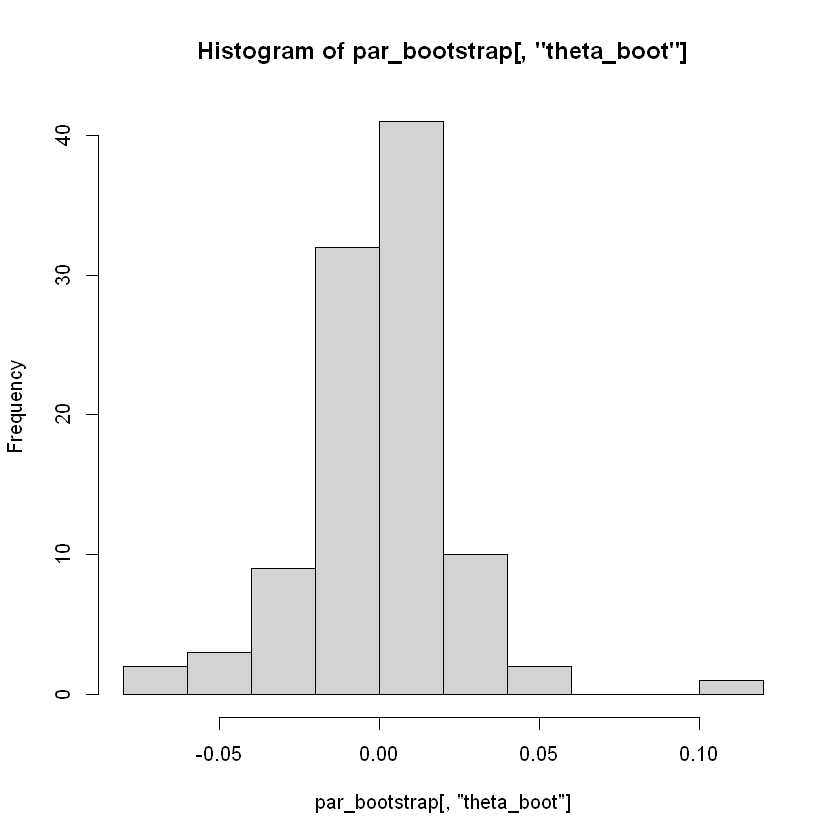

In [56]:
hist(par_bootstrap[,'theta_boot'])

O bootstrap não paramétrico deu errado, como o esperado. Eu montei o experimento Monte Carlo para o código ficar completo:

### Questão 2

In [59]:
Questao2 <- function(B=20,T=100,beta=1,theta=0.3,R=2)
    {
    
    theta_estimado <- numeric(R)
    beta_estimado <- numeric(R)
    mean_theta_bootstrap <- numeric(R)
    mean_beta_bootstrap <- numeric(R)
    IC_theta_bootstrap <- vector("list", R)
    IC_beta_bootstrap <- vector("list", R)
    theta_dif_boot_true <- numeric(R)
    theta_dif_boot_est <- numeric(R)
    beta_dif_boot_true <- numeric(R)
    beta_dif_boot_est <- numeric(R)

    for (r in 1:R)
        {

        Amostra_original<-simulate_glarma(T=100,beta=1,theta=0.3,x=NULL)
        X <- Amostra_original$x
        X <- as.matrix(X)
        colnames(X) <- "Intercept"

        result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
        beta_estimado[r]<-result$delta[1]
        theta_estimado[r]<-result$delta[2]
        
        e<-Amostra_original$e
        e_boot <- replicate(B, sample(e, size = T, replace = TRUE))
        
        par_bootstrap<-bootstrap_n_parametrico(e_boot=e_boot,B=20,mu_init=Amostra_original$mu,y=Amostra_original$y,X=X)
        
        Theta_bootstrap<-par_bootstrap[,'theta_boot']
        Beta_bootstrap<-par_bootstrap[,'beta_boot']

        
        mean_theta_bootstrap[r] <- mean(Theta_bootstrap)
        mean_beta_bootstrap[r] <- mean(Beta_bootstrap)
        
        IC_theta_bootstrap[[r]]<-quantile(Theta_bootstrap, probs = c(0.025, 0.975))
        IC_beta_bootstrap[[r]]<-quantile(Beta_bootstrap, probs = c(0.025, 0.975))
        
        theta_dif_boot_est[r] <- (mean_theta_bootstrap[r] - theta_estimado[r])^2
        theta_dif_boot_true[r] <- (mean_theta_bootstrap[r] - theta)^2

        beta_dif_boot_est[r] <- (mean_beta_bootstrap[r] - beta_estimado[r])^2
        beta_dif_boot_true[r] <- (mean_beta_bootstrap[r] - beta)^2

        }
    return(list('theta_estimado'=theta_estimado,
                'beta_estimado'=beta_estimado,
                'mean_theta_bootstrap'=mean_theta_bootstrap,
                'mean_beta_bootstrap'=mean_beta_bootstrap,
                'IC_theta_bootstrap'=IC_theta_bootstrap,
               'IC_beta_bootstrap'=IC_beta_bootstrap,
                'mean_theta_dif_boot_est' = mean(theta_dif_boot_est, na.rm = TRUE),
                'mean_theta_dif_boot_true' = mean(theta_dif_boot_true, na.rm = TRUE),
                'mean_beta_dif_boot_est' = mean(beta_dif_boot_est, na.rm = TRUE),
                'mean_beta_dif_boot_true' = mean(beta_dif_boot_true, na.rm = TRUE)
                ))
    } 

Testando as funções:

In [60]:
MM_bootstrap_n_parametrico<-Questao2(B=20,R=2)

In [61]:
MM_bootstrap_n_parametrico

$theta_estimado
[1] 0.2828164 0.3258906

$beta_estimado
[1] 1.0440951 0.9498789

$mean_theta_bootstrap
[1] -0.013379773 -0.005092481

$mean_beta_bootstrap
[1] 1.1832643 0.9488612

$IC_theta_bootstrap
$IC_theta_bootstrap[[1]]
       2.5%       97.5% 
-0.15803416  0.06881013 

$IC_theta_bootstrap[[2]]
      2.5%      97.5% 
-0.1285600  0.1013322 


$IC_beta_bootstrap
$IC_beta_bootstrap[[1]]
     2.5%     97.5% 
0.9444775 1.4612103 

$IC_beta_bootstrap[[2]]
     2.5%     97.5% 
0.8329898 1.0974057 


$mean_theta_dif_boot_est
[1] 0.098641

$mean_theta_dif_boot_true
[1] 0.09564415

$mean_beta_dif_boot_est
[1] 0.00968455

$mean_beta_dif_boot_true
[1] 0.01810049

In [62]:
conferindo_cobertura_bootstrap2 <- function(B = 20, T = 100, beta = 1, theta = 0.3, R = 100) {
  
  resultado <- Questao2(B = B, T = T, beta = beta, theta = theta, R = R)

  theta_estimado <- resultado$theta_estimado
  beta_estimado <- resultado$beta_estimado
    
  IC_theta_bootstrap <- resultado$IC_theta_bootstrap
  mean_theta_boot <- resultado$mean_theta_boot

  IC_beta_bootstrap <- resultado$IC_beta_bootstrap
  mean_beta_boot <- resultado$mean_beta_boot
    
  dentro_do_intervalo_theta <- logical(R)
  dentro_do_intervalo_beta <- logical(R)

    
 for (r in 1:R) {
    intervalo_theta <- IC_theta_bootstrap[[r]]
    intervalo_beta <- IC_beta_bootstrap[[r]]
    
    if (any(is.na(intervalo_theta))) {
      dentro_do_intervalo_theta[r] <- NA
      dentro_do_intervalo_beta[r] <- NA
    } else {
      dentro_do_intervalo_theta[r] <- (theta >= intervalo_theta[1]) && (theta <= intervalo_theta[2])
      dentro_do_intervalo_beta[r] <- (beta >= intervalo_beta[1]) && (beta <= intervalo_beta[2])
    }
  }

  cobertura_percentual_theta <- mean(dentro_do_intervalo_theta, na.rm = TRUE) * 100
  cobertura_percentual_beta <- mean(dentro_do_intervalo_beta, na.rm = TRUE) * 100

  
  return(list(
    cobertura_percentual_theta = cobertura_percentual_theta,
    cobertura_percentual_beta = cobertura_percentual_beta,

    total_dentro_theta = sum(dentro_do_intervalo_theta,na.rm=TRUE),
    total_dentro_beta = sum(dentro_do_intervalo_beta,na.rm=TRUE),

    total_r = sum(!is.na(dentro_do_intervalo_theta)),
      
    mean_dif_theta_boot_true = resultado$mean_theta_dif_boot_true,
    mean_dif_theta_boot_est=resultado$mean_theta_dif_boot_est,
    mean_dif_beta_boot_true = resultado$mean_beta_dif_boot_true ,
    mean_dif_beta_boot_est=resultado$mean_beta_dif_boot_est
  ))
}


In [63]:
conferindo_cobertura_bootstrap2(R=2)

$cobertura_percentual_theta
[1] 0

$cobertura_percentual_beta
[1] 0

$total_dentro_theta
[1] 0

$total_dentro_beta
[1] 0

$total_r
[1] 2

$mean_dif_theta_boot_true
[1] 0.08492174

$mean_dif_theta_boot_est
[1] 0.09278277

$mean_dif_beta_boot_true
[1] 0.5966138

$mean_dif_beta_boot_est
[1] 0.4578075

Já sabemos que o não paramétrico está errado, logo fiz poucas iterações.

# Questão 3

criando a funçao que faz previsões no modelo glarma:

In [5]:
prev_glarma <- function(y, x, beta, theta, seed = NULL) {

 futuro_x <- rep(mean(x[, 1], na.rm = TRUE), 1)

  if (!is.null(seed)) set.seed(seed)
  
  T <- length(y)
  mu <- numeric(T)
  e <- numeric(T)
  z <- numeric(T)
  
  #passo 1, reconstruir z,e,mu
    
  for (t in 1:T) {
      
    z_t <- if (t > 1) e[t - 1] * theta else 0
    eta <- beta * x[t] + z_t
    mu[t] <- exp(eta)
    e[t] <- (y[t] - mu[t]) / sqrt(mu[t])
    z[t] <- z_t
  }
  
    e_t <- e[T]

    z_t <- e_t * theta

    eta <- beta * futuro_x + z_t
   
    y_pred <-  exp(eta)



  return(list('y_pred'= y_pred))
}


criando uma função que faz o Intervalo preditivo bootstrap utilizando o bootstrap paramétrico já apresentado.

In [42]:
intervalo_preditivo_bootstrap <- function(T=100,B=100, beta = 1, theta = 0.3,R=2){
    
    mean_Y_pred <- numeric(R)
    IC_pred <- vector("list", R)
    Y_teste <- numeric(R)
    
    x_train <- rep(1,(T-1))
    x_train <- as.matrix(x_train)
    colnames(x_train) <- "Intercept"
    
    for (r in 1:R)
    {
        
    Y_pred<-numeric(B)
    beta_boot<-numeric(B)
    theta_boot<-numeric(B)
        
    boot <- bootstrap_parametrico(T=T,B=B, beta = 1, theta = 0.3)
    
    Y <- boot$Amostra_original
    Y_train = Y[1:(T-1)]
    Y_test = Y[T]
    
    theta_boot<-boot$Theta_bootstrap$theta
    beta_boot<-boot$Beta_bootstrap$beta
    
    for (b in 1:B)
        {
        prev<-prev_glarma(y=Y_train,x=x_train,beta=beta_boot[b],theta=theta_boot[b])
        Y_pred[b]<-prev$y_pred
        }
        
    mean_Y_pred[r]=mean(Y_pred,na.rm=TRUE)
        
    IC_pred[[r]]<-quantile(Y_pred,probs = c(0.025, 0.975),na.rm=TRUE)
    IC_pred[[r]] <- c(floor(IC_pred[[r]][1]), ceiling(IC_pred[[r]][2]))

    Y_teste[r]<-Y_test
    }
    
        return(list('Y_test'=Y_teste,'IC_pred'=IC_pred))
}

Eu arredondei os limites dos intervalos para o inteiro mais próximo, pois o Y_test é inteiro.

conferindo_IP verifica o percentual de intervalos que contém o Y_teste:

In [38]:
conferindo_IP <- function(B = 100, T = 100, beta = 1, theta = 0.3, R=2) {
  
  dentro_do_intervalo <- logical(R)

    resultado <- intervalo_preditivo_bootstrap(T=T,B=B, beta = beta, theta = theta,R=R)

    Y_test <- resultado$Y_test
    IC_pred <- resultado$IC_pred
  
  for (r in 1:R) {
    
    intervalo <- IC_pred[[r]]
    
    if (any(is.na(intervalo))) {
      dentro_do_intervalo[r] <- NA
    } else {
    dentro_do_intervalo[r] <- (Y_test[r] >= intervalo[1]) && (Y_test[r] <= intervalo[2])
    }
  }

  cobertura_percentual <- mean(dentro_do_intervalo,na.rm = TRUE) * 100
  
  return(list(
    total_dentro = sum(dentro_do_intervalo,na.rm = TRUE),
    cobertura_percentual = cobertura_percentual,    
    total_R = sum(!is.na(dentro_do_intervalo))    
  ))
    
}

In [39]:
conferindo_IP(R=10,B=50)

$total_dentro
[1] 8

$cobertura_percentual
[1] 80

$total_R
[1] 10

Nos 10 experimentos feitos, o Y_teste está no intervalo 8 vezes. 

Fiquei com dúvida na questão 3, poderia me ajudar após a entrega do trabalho?